In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm

In [9]:
def common_results_list(a, b):
    """
    Implementation of Common Results List.
    
    Determines the number of elements not in both lists using the XOR operator ^.
    
    params:
    a, b: lists to compare
    
    returns:CRL as integer 
    """
    return len(set(a) ^ set(b))

def RBO(a, b, p=0.9):
    """
    Implementation of Rank Biased Overlap, definition as taken from (Webber, Moffat, & Zobel, 2010)
    
    Calculates the overlap between the two lists up to depth d, normalizes it by the depth,
    and sums these values weighted by p to the power d - 1 for each depth up to the length of array a
    
    params:
    a, b: lists to compare
    p: weight parameter that determines how much the top few results add to the overall metric.
    
    returns: RBO as double between 0 and 1
    """
    s = 0
    for d in range(1, len(a) + 1):
        Xd = len(set(a[:d]) & set(b[:d]))
        Ad = Xd / d
        s += p ** (d - 1) * Ad
    return (1 - p) * s

def deviation_per_rank(a, b):
    """
    Implementation of Deviation Per Rank, returns the mean over each of the values
    
    Assumes len(a) == len(b)
    
    Params:
    a, b: lists to compare
    
    returns: deviation per rank as list of length len(a)
    """
    def delta(x, y):
        return 1 if x == y else 0
    
    n = 2  # for our experiment we always only use 2 lists
    deviations = [(1 - delta(a[k], b[k])) / n / (n - 1) for k in range(len(a))]
    return np.mean(deviations)

def kendall_tau(a, b):
    """
    Applies scipy.stats kendall tau function.
    
    Note the version of Kendall-Tau used: (P - Q) / sqrt((P + Q + T) * (P + Q + U)) with:
    P = #concordant pairs, Q = #discordant pairs, T = #ties only in a, U = #ties only in b
    """
    tau, p = stats.kendalltau(a, b)
    return tau

In [10]:
camera_control = [1, 2, 3, 4, 5, 6, 7, 8]
camera_test5   = [0, 1, 3, 2, 4, 6, 9, 7]  # notes: 0 was an ad for control
camera_test15  = [0, 1, 3, 2, 4, 6, 9, 10]  # notes: only 7 actual results, counted first ad because this was actual result for test5
camera_test25  = [0, 1, 3, 2, 4, 6, 9, 8]

play_control = [1, 2, 3, 4, 5, 6, 7, 8]
play_test5   = [1, 2, 3, 5, 6, 4, 9, 8]
play_test15  = [1, 2, 3, 5, 6, 4, 9, 8]
play_test25  = [1, 2, 3, 5, 6, 4, 9, 8]
# notes: all the same, already fully personalized after 5 queries

sam_control = [1, 2, 3, 4, 5, 6, 7, 8]  # notes: 9 results instead of 8, omitted last one
sam_test5   = [1, 2, 3, 4, 7, 8, 9, 0]
sam_test15  = [1, 2, 3, 4, 7, 8, 9, 0]
sam_test25  = [1, 2, 3, 4, 5, 6, 7, 8]  # notes: interesting that personalization is undone after too many queries.
                                        # possible explanation: few queries = 'want to purchase', more = 'interested' so also news articles etc.

In [15]:
anime_control = [1, 2, 3, 4, 5, 6, 7, 8]
anime_test5   = [1, 2, 3, 4, 5, 6, 7, 0]
anime_test15  = [1, 2, 3, 4, 5, 6, 7, 8]
anime_test25  = [1, 2, 3, 4, 5, 6, 7, 8]

marvel_control = [1, 2, 3, 4, 5, 6, 7, 8]  # notes: comics - wikipedia page shows up twice
marvel_test5   = [1, 2, 3, 4, 5, 6, 7, 8]  # notes: 0 is an ad but it is the 9th result
marvel_test15  = [1, 2, 3, 4, 5, 6, 7, 8]
marvel_test25  = [1, 2, 3, 4, 5, 6, 7, 8]
# for above 9th result was removed

spotify_control = [1, 2, 3, 4, 5, 6, 7, 8]
spotify_test5   = [1, 3, 2, 4, 5, 6, 7, 8]
spotify_test15  = [1, 2, 3, 4, 5, 6, 7, 8]
spotify_test25  = [1, 2, 3, 4, 5, 6, 7, 8]

In [16]:
privacy_control = [1, 2, 3, 4, 5, 6, 7, 8]
privacy_test5   = [1, 2, 3, 4, 5, 7, 6, 9]  # notes; fully personalized after only 5 queries
privacy_test15  = [1, 2, 3, 4, 5, 7, 6, 9]
privacy_test25  = [1, 2, 3, 4, 5, 7, 6, 9]

climate_control = [1, 2, 3, 4, 5, 6, 7, 8]
anti_test5  = [1, 9, 2, 5, 3, 4, 6, 0]
anti_test15 = [1, 9, 2, 5, 3, 4, 0, 10]  # 5 and 25 have 1 more result, this one has 3/4 more ads
anti_test25 = [1, 9, 2, 5, 3, 4, 6, 0]
pro_test5   = [1, 2, 5, 3, 4, 6, 0, 11]  # 11 also occurs in anti 5 & 25, but was omitted due to being 9th result
pro_test15  = [1, 2, 5, 3, 4, 6, 0, 10]
pro_test25  = [1, 2, 12, 5, 3, 4, 6, 11]

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot(labels, f, data, title):
    width = 0.25
    x = np.arange(len(labels))

    fives       = [f(control, test) for control, test in data[0]]
    fifteens    = [f(control, test) for control, test in data[1]]
    twentyfives = [f(control, test) for control, test in data[2]]
    
    plt.figure(figsize=(10, 5))
    plt.bar(x - width, fives,       width, label='5', color='paleturquoise')
    plt.bar(x,         fifteens,    width, label='15', color='lightseagreen')
    plt.bar(x + width, twentyfives, width, label='25', color='steelblue')
    plt.ylabel('Scores')
    plt.title(title)
    plt.xticks(x, labels)
    plt.legend()

    plt.tight_layout()
    plt.show()

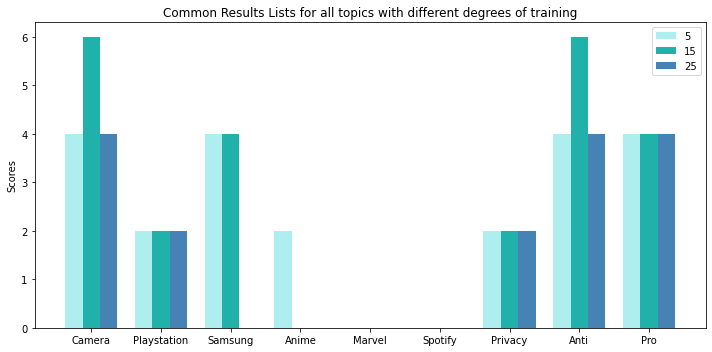

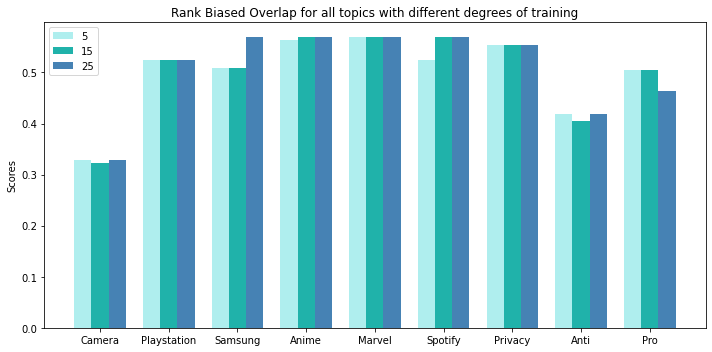

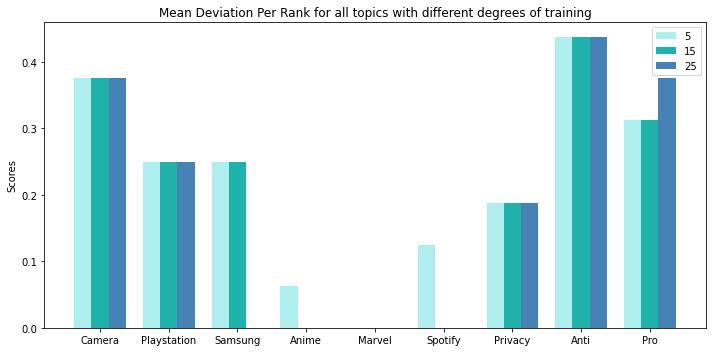

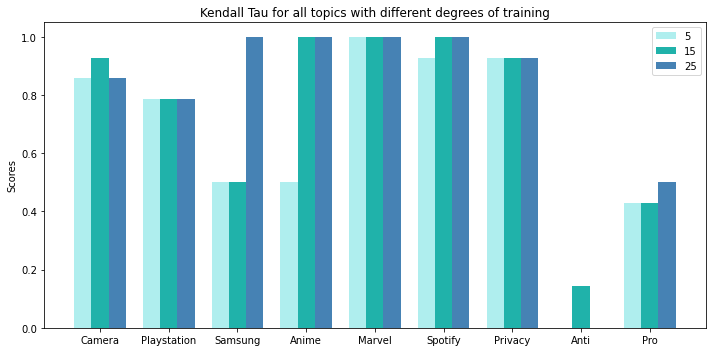

In [18]:
labels = ['Camera', 'Playstation', 'Samsung', 'Anime', 'Marvel', 'Spotify', 'Privacy', 'Anti', 'Pro']
data = [[(camera_control, camera_test5), (play_control, play_test5), (sam_control, sam_test5),
         (anime_control, anime_test5), (marvel_control, marvel_test5), (spotify_control, spotify_test5),
         (privacy_control, privacy_test5), (climate_control, anti_test5), (climate_control, pro_test5)],
        [(camera_control, camera_test15), (play_control, play_test15), (sam_control, sam_test15),
         (anime_control, anime_test15), (marvel_control, marvel_test15), (spotify_control, spotify_test15),
         (privacy_control, privacy_test15), (climate_control, anti_test15), (climate_control, pro_test15)],
        [(camera_control, camera_test5), (play_control, play_test25), (sam_control, sam_test25),
         (anime_control, anime_test25), (marvel_control, marvel_test25), (spotify_control, spotify_test25),
         (privacy_control, privacy_test25), (climate_control, anti_test25), (climate_control, pro_test25)]]
title = 'Common Results Lists for all topics with different degrees of training'
plot(labels, common_results_list, data, title)
title = 'Rank Biased Overlap for all topics with different degrees of training'
plot(labels, RBO, data, title)
title = 'Mean Deviation Per Rank for all topics with different degrees of training'
plot(labels, deviation_per_rank, data, title)
title = 'Kendall Tau for all topics with different degrees of training'
plot(labels, kendall_tau, data, title)